## Absorption spectrum of graphene nanoflakes

This example demonstrates an advanced simulation. We will initialize a triangular graphene nanoflake, specify the couplings, simulate it under pulsed illumination and compute the absorption spectrum.

### Set up the Stack

The setup is analogous to the first tutorial. We build the Stack using the StackBuilder, which needs to know the material (a triangular armchair graphene nanoflake of 7.4 Å) and the coupling between the pz-orbitals (hopping rates and Coulomb interaction).

In [16]:
import granad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

sb = granad.StackBuilder()

# geometry
triangle = granad.Triangle(7.4) 
graphene = granad.Lattice(
    shape=triangle,
    lattice_type=granad.LatticeType.HONEYCOMB,
    lattice_edge=granad.LatticeEdge.ARMCHAIR,
    lattice_constant=2.46,
)
sb.add("pz", graphene)

# couplings
hopping_graphene = granad.LatticeCoupling(
    orbital_id1="pz", orbital_id2="pz", lattice=graphene, couplings=[0, -2.66] # list of hopping amplitudes like [onsite, nn, ...]
)
sb.set_hopping(hopping_graphene)
coulomb_graphene = granad.LatticeCoupling(
    orbital_id1="pz",
    orbital_id2="pz",
    lattice=graphene,
    couplings=[16.522, 8.64, 5.333],
    coupling_function=lambda d: 14.399 / d + 0j,
)
sb.set_coulomb(coulomb_graphene)

stack = sb.get_stack()

We now define the electric field as an x-polarized pulse of frequency peaking at 2, with fwhm of 0.5.

In [21]:
amplitudes = [1, 0, 0]
frequency = 1
peak = 2
fwhm = 0.5
field_func = granad.electric_field_pulse(
    amplitudes, frequency, stack.positions[0, :], peak, fwhm
)

We assume the structure looses energy relaxing across all channels with a rate of 0.1

In [22]:
loss_function = granad.relaxation( 0.1 )

We propagate the structure in time. The function evolution returns a tuple. First is a new stack. Second is an array of density matrices. We only need the diagonal entries of the density matrices. So we apply the corresponding postprocessing function.

In [29]:
time_axis = jnp.linspace(0, 10, 10**4) 
new_stack, occupations = granad.evolution(
    stack,
    time_axis,
    field_func,
    loss_function,
    postprocess = jnp.diag
)

We now plot the absorption 

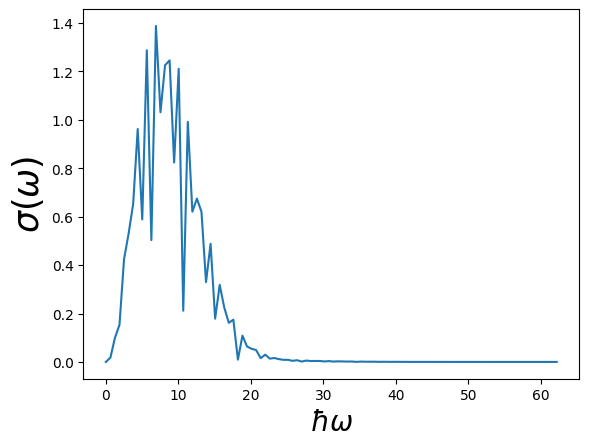

In [28]:
## custom function for performing the fourier transform
def get_fourier_transform(t_linspace, function_of_time):
    function_of_omega = np.fft.fft(function_of_time) / len(t_linspace)
    omega_axis = (
        2
        * np.pi
        * len(t_linspace)
        / np.max(t_linspace)
        * np.fft.fftfreq(function_of_omega.shape[-1])
    )
    return omega_axis, function_of_omega


# dipole moments in fourier space
dipole_moment = granad.induced_dipole_moment(stack, occupations)
omega_axis, dipole_omega = get_fourier_transform(time_axis, dipole_moment[:, 0])

# we also need the x-component of the electric field as a single function
electric_field = granad.electric_field(
    amplitudes, frequency, stack.positions[0, :]
)(time_axis)
_, field_omega = get_fourier_transform(time_axis, electric_field[0])


omega_max = 100
component = 0
# alpha = p / E
polarizability = dipole_omega / field_omega
# sigma ~ Im[alpha]
spectrum = -omega_axis[:omega_max] * np.imag(polarizability[:omega_max])
plt.plot(omega_axis[:omega_max], np.abs(spectrum) ** (1 / 2))
plt.xlabel(r"$\hbar\omega$", fontsize=20)
plt.ylabel(r"$\sigma(\omega)$", fontsize=25)
plt.show()